In [41]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

In [2]:
# Set batch size
batch_size = 32

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)), # Resize the images
    transforms.Grayscale(num_output_channels=1), # Convert to grayscale
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Load the dataset from the folders
dataset = ImageFolder(root='./brain-tumor-data-set', transform=transform)

# Split the dataset
train_size = int(0.8 * len(dataset)) # 80% for training 
test_size = len(dataset) - train_size  # The rest for testing

# Create subsets
trainset, testset = random_split(dataset, [train_size, test_size])

# Create data loaders
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# Define the class names (labels)
classes = ('Brain Tumor', 'Healthy')

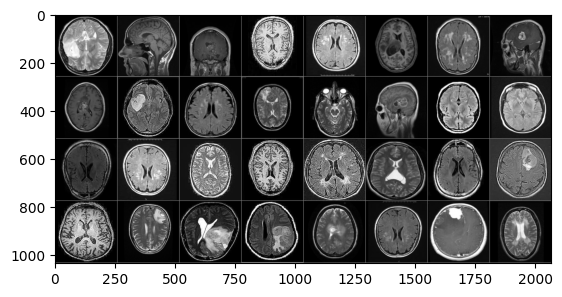

Brain Tumor Healthy Brain Tumor Healthy Healthy Healthy Healthy Brain Tumor Brain Tumor Brain Tumor Healthy Healthy Healthy Brain Tumor Healthy Healthy Healthy Healthy Healthy Healthy Healthy Brain Tumor Healthy Brain Tumor Healthy Brain Tumor Brain Tumor Brain Tumor Brain Tumor Healthy Brain Tumor Healthy


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images and print labels
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.relu1 = nn.ReLU() 
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.relu2 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(20 * 248 * 248, 50)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(50, 10)
        self.fc3 = nn.Linear(10, 2) # 2 Classes (Brain Tumor / Healthy)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

net = Net()

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [6]:
num_epochs = 5  # Number of epochs to train

for epoch in range(num_epochs):  # Loop over the dataset multiple times
    net.train()  # Set the model to training mode
    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(trainloader):
        # Zero the parameter gradients after each batch
        optimizer.zero_grad()
        
        # Forward pass
        outputs = net(inputs)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_loss += loss.item()
        if batch_idx % 500 == 499:  # Print every 100 mini-batches
            print(f'Epoch {epoch+1}, Batch {batch_idx+1}, Loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')

Finished Training


In [7]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

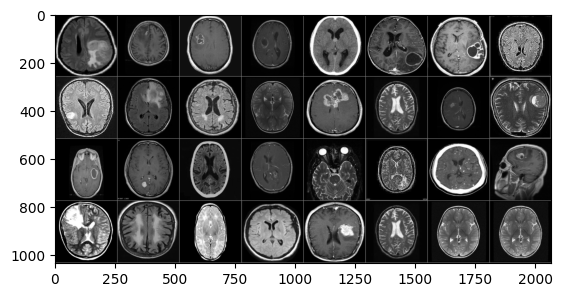

GroundTruth:  Brain Tumor Brain Tumor Brain Tumor Brain Tumor


In [8]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [9]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [10]:
outputs = net(images)

In [11]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  Brain Tumor Brain Tumor Brain Tumor Brain Tumor


In [12]:
correct = 0
total = 0
# Since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Calculate outputs by running images through the network
        outputs = net(images)
        # The class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 95 %


In [13]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Brain Tumor is 96.8 %
Accuracy for class: Healthy is 95.0 %


/tmp/ipykernel_5931/2395750269.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(PATH))


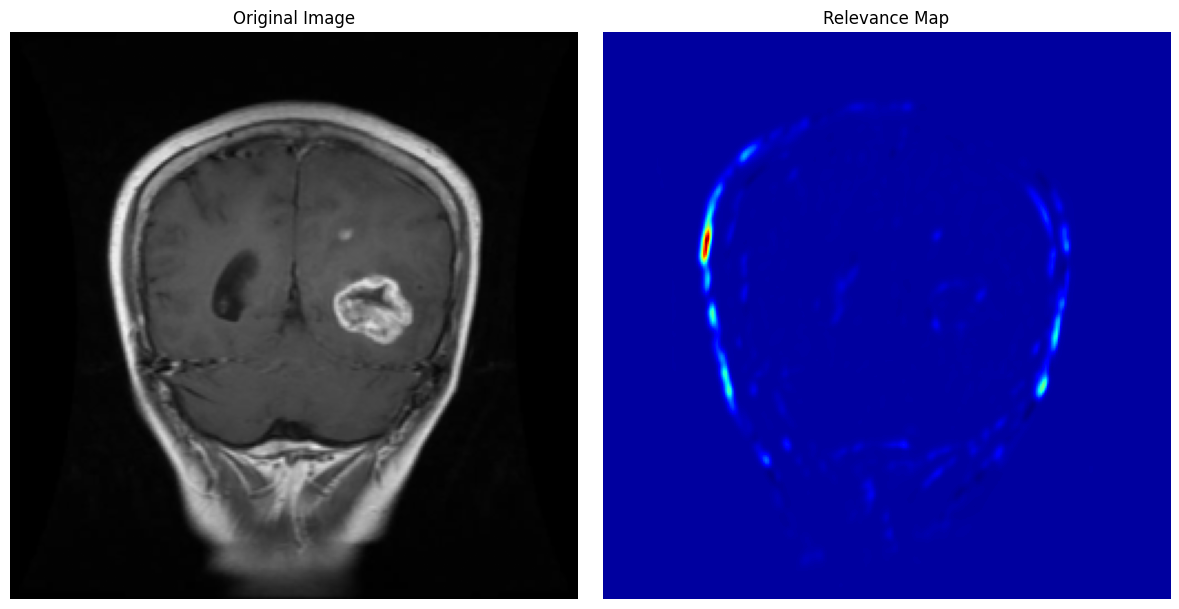

In [85]:
import importlib
import lrp
importlib.reload(lrp)
from lrp import LRPModel
from PIL import Image
import matplotlib.pyplot as plt

def load_LRP():
    net = Net()
    net.load_state_dict(torch.load(PATH))
    return LRPModel(net)

def run_LRP(lrp_model, image):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    input_tensor = transform(image).unsqueeze(0)  # Load or preprocess an input image tensor
    return lrp_model.forward(input_tensor)

def create_relevance_map(relevance_map, image):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    input_image_np = transform(image).detach().numpy()
    input_image_np = input_image_np.transpose(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    input_image_np = (input_image_np * 0.5 + 0.5)  # Unnormalize to [0, 1]

    relevance_map = (relevance_map - relevance_map.min()) / (relevance_map.max() - relevance_map.min())

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(input_image_np)
    axes[0].set_title("Original Image")
    axes[0].axis('off')  # Hide axes

    axes[1].imshow(relevance_map, cmap='jet')
    axes[1].set_title("Relevance Map")
    axes[1].axis('off')  # Hide axes

    fig.tight_layout()
    plt.show()

image = Image.open('./brain-tumor-data-set/Brain-Tumor/Cancer (887).jpg')
lrp_model = load_LRP()
relevance_map = run_LRP(lrp_model, image)
create_relevance_map(relevance_map, image)